In [1]:
import io
import subprocess
import os
import glob
import sys
import pwd

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings
import statsmodels.stats.multitest as smm
import json

from pathlib import Path
from midas import m
from datetime import datetime, date
import altair as alt

# gh specific
sys.path.append('/ghsfa/projects/pharma/shared_scripts/')
import bibp.functions as functions
import hgvslib.pHGVS as pHGVS  ## do a pull on the hgvslib git repo

# !pip install statannotations==0.4.0
# #!pip uninstall statannotations --yes
# from statannotations.Annotator import Annotator

warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
work_dir="/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024"

# SOW157 TFv2 update

## Data preocessing

In [4]:
# Readin cummulative reports 

# SOW157 from /ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW157_Infinity/AZN_SOW157_03/molecular_response/cumulative_report.csv
df_sow157_all = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW157_Infinity/AZN_SOW157_03/molecular_response/cumulative_report.csv", header = 0) 

print("Total sample size of SOW157 Infinity cumulative batches is " + str(df_sow157_all.shape[0]) + "\n") 
print("Total unique sample size of SOW157 Infinity cumulative batches is " + str(df_sow157_all.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of SOW157 Infinity cumulative batches is " + str(df_sow157_all.Patient_ID.nunique()) + "\n")

df_sow157_all.head()

Total sample size of SOW157 Infinity cumulative batches is 20632

Total unique sample size of SOW157 Infinity cumulative batches is 654

Total unique patient sample size of SOW157 Infinity cumulative batches is 654



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,VHL,3,10183650.0,1.0,P40L,C>T,c.119C>T,NM_000551.4,54.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV56544096,rs200343185,Conflicting_interpretations_of_pathogenicity,139144.0,NaN,NaN,869.0,6.01,Detected,0.025836,9.52,Low,Not Detected,14.716,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable
1,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,GRIN2A,16,10032356.0,4.0,T156M,G>A,c.467C>T,NM_000833.5,53.98,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV58053815,rs763500409,Uncertain_significance,645270.0,NaN,NaN,1873.0,6.01,Detected,0.025836,9.52,Low,Not Detected,14.716,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable
2,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,RUNX1,21,36164478.0,9.0,M466R,A>C,c.1397T>G,NM_001754.5,53.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1284.0,6.01,Detected,0.025836,9.52,Low,Not Detected,14.716,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable
3,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,NOTCH3,19,15271813.0,33.0,P2209L,G>A,c.6626C>T,NM_000435.3,51.95,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV54644859,rs541716070,Likely_benign,688969.0,NaN,NaN,2593.0,6.01,Detected,0.025836,9.52,Low,Not Detected,14.716,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable
4,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,AXIN1,16,396165.0,2.0,S287S,G>A,c.861C>T,NM_003502.4,50.30,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV51987792,rs755122731,NaN,NaN,NaN,NaN,1675.0,6.01,Detected,0.025836,9.52,Low,Not Detected,14.716,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable


In [5]:
# Remove duplication
df_sow157_dedup = df_sow157_all.drop_duplicates(subset = "GHSampleID")
df_sow157_dedup.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,VHL,3,10183650.0,1.0,P40L,C>T,c.119C>T,NM_000551.4,54.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV56544096,rs200343185,Conflicting_interpretations_of_pathogenicity,139144.0,NaN,NaN,869.0,6.01,Detected,0.025836,9.52,Low,Not Detected,14.7160,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable
25,D933AC00001,6511986157,A0904054,B00548158,E0201005,C1D1,1,SUCCESS,NaN,SNV,NaN,DICER1,14,95570373.0,21.0,N1120N,A>G,c.3360T>C,NM_177438.3,51.03,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Likely_benign,693629.0,NaN,NaN,1693.0,1.09,Not Detected,0.000000,4.73,Low,Not Detected,11.7000,2.0,0.0,11/14/2023,12/15/2020,01/05/2024,NaN,Not Applicable,Not Applicable
44,D933AC00001,6511640187,A0904085,B00548113,E0209011,C1D1,1,SUCCESS,NaN,SNV,NaN,PTPRD,9,8518099.0,21.0,S431L,G>A,c.1292C>T,NM_002839.4,57.17,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV61926988,rs764400127,NaN,NaN,NaN,NaN,3161.0,12.07,Detected,0.132090,15.12,Low,Not Detected,61.8800,2.0,0.0,11/14/2023,06/17/2020,01/05/2024,NaN,Not Applicable,Not Applicable
77,D933AC00001,6510376467,A0904021,B00548183,E1202001,C1D1,1,SUCCESS,NaN,SNV,NaN,AMER1,X,63411301.0,2.0,E622D,C>G,c.1866G>C,NM_152424.4,100.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,726.0,1.00,Detected,0.002334,2.36,Low,Not Detected,5.1584,3.0,0.0,11/14/2023,02/19/2020,01/05/2024,NaN,Not Applicable,Not Applicable
91,D933AC00001,6510376468,A0904026,B00548195,E1202002,C1D1,1,SUCCESS,NaN,SNV,NaN,JAK3,19,17945407.0,17.0,R775C,G>A,c.2323C>T,NM_000215.4,54.20,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200624610,not_provided,138313.0,NaN,NaN,3797.0,6.89,Detected,0.056181,4.73,Low,Not Detected,40.8200,3.0,0.0,11/14/2023,03/05/2020,01/05/2024,NaN,Not Applicable,Not Applicable


In [6]:
# Pull "runid" from ghdb
df_sow157_1 = df_sow157_dedup.copy()

# Define the IDs you want to query for
ids = tuple(df_sow157_1['GHSampleID'].unique())

# Generate the SQL query string
query = "SELECT * FROM gh_sample WHERE run_sample_id IN {}".format(ids)

# Get the dataframe with "runid"
sample_df = functions.run_sql_query(query)
sample_df.head()

# Merge "runid" 
sample_df = sample_df.rename(columns={"run_sample_id": "GHSampleID"})
df_sow157_1 = df_sow157_1.merge(sample_df[['GHSampleID', 'runid']], on = 'GHSampleID', how = "left")
df_sow157_1.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid
0,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,VHL,3,10183650.0,1.0,P40L,C>T,c.119C>T,NM_000551.4,54.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV56544096,rs200343185,Conflicting_interpretations_of_pathogenicity,139144.0,NaN,NaN,869.0,6.01,Detected,0.025836,9.52,Low,Not Detected,14.7160,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01907_0179_BHKJJLDSX7
1,D933AC00001,6511986157,A0904054,B00548158,E0201005,C1D1,1,SUCCESS,NaN,SNV,NaN,DICER1,14,95570373.0,21.0,N1120N,A>G,c.3360T>C,NM_177438.3,51.03,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Likely_benign,693629.0,NaN,NaN,1693.0,1.09,Not Detected,0.000000,4.73,Low,Not Detected,11.7000,2.0,0.0,11/14/2023,12/15/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01907_0178_AHKJTFDSX7
2,D933AC00001,6511640187,A0904085,B00548113,E0209011,C1D1,1,SUCCESS,NaN,SNV,NaN,PTPRD,9,8518099.0,21.0,S431L,G>A,c.1292C>T,NM_002839.4,57.17,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV61926988,rs764400127,NaN,NaN,NaN,NaN,3161.0,12.07,Detected,0.132090,15.12,Low,Not Detected,61.8800,2.0,0.0,11/14/2023,06/17/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01907_0179_BHKJJLDSX7
3,D933AC00001,6510376467,A0904021,B00548183,E1202001,C1D1,1,SUCCESS,NaN,SNV,NaN,AMER1,X,63411301.0,2.0,E622D,C>G,c.1866G>C,NM_152424.4,100.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,726.0,1.00,Detected,0.002334,2.36,Low,Not Detected,5.1584,3.0,0.0,11/14/2023,02/19/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01021_0576_AHKJTYDSX7
4,D933AC00001,6510376468,A0904026,B00548195,E1202002,C1D1,1,SUCCESS,NaN,SNV,NaN,JAK3,19,17945407.0,17.0,R775C,G>A,c.2323C>T,NM_000215.4,54.20,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200624610,not_provided,138313.0,NaN,NaN,3797.0,6.89,Detected,0.056181,4.73,Low,Not Detected,40.8200,3.0,0.0,11/14/2023,03/05/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01021_0576_AHKJTYDSX7


In [7]:
def add_fc_dir_column(df):
    """
    Adds a 'fc_dir' column to the given dataframe, specifying the FC path based on the 'runid' column.

    Args:
        df (pd.DataFrame): A DataFrame that must contain a 'runid' column. This column is used to
                           match directory paths from predefined locations.

    Returns:
        pd.DataFrame: The original dataframe with an added 'fc_dir' column indicating the directory path
                      corresponding to each 'runid'. If no directory is found, the path will be an empty string.
        pd.DataFrame: A DataFrame containing the rows for which no directory path was found.
    """
    # Define the path
    fc_dir_all = "/ghsfa/ivd/flowcentral"
    fc_dir_omni = "/ghsfa/projects/omni_v2/flowcells"
    
    # Initialize a list to store rows where no BIP output was found
    rows_no_found = []
    
    # Initialize the new column in the DataFrame
    df['fc_dir'] = ''
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        runid = row["runid"]
        
        # Find original folder
        pattern_ori = f"{fc_dir_all}/*{runid}*"
        folders = glob.glob(pattern_ori)
        if folders:
            df.loc[index, 'fc_dir'] = folders[0]
        else:
            # Search in the alternative directory if no folder found in the first directory
            pattern_omni = f"{fc_dir_omni}/*{runid}*"
            folders_omni = glob.glob(pattern_omni)
            if folders_omni:
                df.loc[index, 'fc_dir'] = folders_omni[0]
            else:
                # Append the row to the list if no folder is found in either location
                rows_no_found.append(row)
    
    # Create a DataFrame with rows where folders were not found in any sources
    df_no_fc_dir = pd.DataFrame(rows_no_found)
    
    return df, df_no_fc_dir

# Generate the new dataframe 
df_sow157_2, df_no_found = add_fc_dir_column(df_sow157_1)

print("Total sample size of SOW157 Infinity cumulative batches with fc_dir is " + str(df_sow157_1.shape[0]) + "\n") 
print("Total sample size of SOW157 Infinity cumulative batches with NO fc_dir is " + str(df_no_found.shape[0]) + "\n") 

df_sow157_2.head()



Total sample size of SOW157 Infinity cumulative batches with fc_dir is 654

Total sample size of SOW157 Infinity cumulative batches with NO fc_dir is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir
0,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,VHL,3,10183650.0,1.0,P40L,C>T,c.119C>T,NM_000551.4,54.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV56544096,rs200343185,Conflicting_interpretations_of_pathogenicity,139144.0,NaN,NaN,869.0,6.01,Detected,0.025836,9.52,Low,Not Detected,14.7160,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01907_0179_BHKJJLDSX7,/ghsfa/ivd/flowcentral/231201_A01907_0179_BHKJJLDSX7.e5026e67-a80a-4dd6-b8f6-f44b497b38d7.20231203120455
1,D933AC00001,6511986157,A0904054,B00548158,E0201005,C1D1,1,SUCCESS,NaN,SNV,NaN,DICER1,14,95570373.0,21.0,N1120N,A>G,c.3360T>C,NM_177438.3,51.03,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Likely_benign,693629.0,NaN,NaN,1693.0,1.09,Not Detected,0.000000,4.73,Low,Not Detected,11.7000,2.0,0.0,11/14/2023,12/15/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01907_0178_AHKJTFDSX7,/ghsfa/ivd/flowcentral/231201_A01907_0178_AHKJTFDSX7
2,D933AC00001,6511640187,A0904085,B00548113,E0209011,C1D1,1,SUCCESS,NaN,SNV,NaN,PTPRD,9,8518099.0,21.0,S431L,G>A,c.1292C>T,NM_002839.4,57.17,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV61926988,rs764400127,NaN,NaN,NaN,NaN,3161.0,12.07,Detected,0.132090,15.12,Low,Not Detected,61.8800,2.0,0.0,11/14/2023,06/17/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01907_0179_BHKJJLDSX7,/ghsfa/ivd/flowcentral/231201_A01907_0179_BHKJJLDSX7.e5026e67-a80a-4dd6-b8f6-f44b497b38d7.20231203120455
3,D933AC00001,6510376467,A0904021,B00548183,E1202001,C1D1,1,SUCCESS,NaN,SNV,NaN,AMER1,X,63411301.0,2.0,E622D,C>G,c.1866G>C,NM_152424.4,100.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,726.0,1.00,Detected,0.002334,2.36,Low,Not Detected,5.1584,3.0,0.0,11/14/2023,02/19/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01021_0576_AHKJTYDSX7,/ghsfa/ivd/flowcentral/231201_A01021_0576_AHKJTYDSX7
4,D933AC00001,6510376468,A0904026,B00548195,E1202002,C1D1,1,SUCCESS,NaN,SNV,NaN,JAK3,19,17945407.0,17.0,R775C,G>A,c.2323C>T,NM_000215.4,54.20,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200624610,not_provided,138313.0,NaN,NaN,3797.0,6.89,Detected,0.056181,4.73,Low,Not Detected,40.8200,3.0,0.0,11/14/2023,03/05/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01021_0576_AHKJTYDSX7,/ghsfa/ivd/flowcentral/231201_A01021_0576_AHKJTYDSX7


## Generate Pancancer S3 MB caller outputs for SOW157
#### Notes:
    1. No cancer type provided
    2. Sample size of cumulative report is inconsistent with the sum of 3 batches based on file names
###### Git clone Sirius-1.6.0_Release_Branch for region_file and control_file files for different S3 MB callers
###### Branch https://github.com/guardant/bip-products/blob/Sirius-1.6.0_Release_Branch/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml#L653-L680
###### Confluence page to follow: https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update

In [4]:
# import epicaller
# import epicaller.methylation.methyl_caller

# def run_s3_pancancer_caller_wrapper_slurm(sample_meta_df, mr_model_file, workdir):
#     region_file = f"{workdir}/bip-products/models/Sirius/caller_models/pancancer/pancancer_s3_mafband.tsv"
#     control_region_file = f"{workdir}/bip-products/models/Sirius/caller_models/pancancer/pancancer_s3_mafband_control_regions.tsv"
#     lr_model_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv'  # lr does not matter

#     jobs_dir = f"{workdir}/MB_pan_SOW157_jobs"
#     output_dir = f"{workdir}/MB_pan_SOW157_output"

#     # Check and create directories if not exists
#     if not os.path.exists(jobs_dir):
#         os.makedirs(jobs_dir)

#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     for _, row in sample_meta_df.iterrows():
#         run_sample_id = row["GHSampleID"]
#         fc_dir = row["fc_dir"]
#         flowcell_id = row["runid"]
#         mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
#         mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
#         # Check if the molecule file exists
#         if not os.path.exists(mbd_hyper_molecules):
#             continue

#         job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
#         shebang_content = (f"#!/bin/bash\n"
#                            f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
#                            f"#SBATCH --nodes=1\n"
#                            f"#SBATCH --ntasks=1\n"
#                            f"#SBATCH --cpus-per-task=1\n"
#                            f"#SBATCH --mem=30gb\n"
#                            f"#SBATCH --partition=dev\n"
#                            f"#SBATCH --time=00:10:00\n"
#                            f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
#         with open(job_file, "w") as job_output:
#             job_output.write(shebang_content)
#             job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
#                              f"--hyper-molecule-file {mbd_hyper_molecules} " + 
#                              f"--residual-molecule-file {mbd_residual_molecules} " + 
#                              f"--region-file {region_file} " +
#                              f"--control-region-file {control_region_file} " + 
#                              f"--lr-model-file {lr_model_file} " + 
#                              f"--mr-model-file {mr_model_file} " +
#                              "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
#                              f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {output_dir}/")
#             # print(job_output)    
#         os.system(f"sbatch {job_file}")


In [ ]:
# #run the function to generate S3 pancancer caller ouputs for SOW157 batch 
# run_s3_pancancer_caller_wrapper_slurm(df_sow157_2, 
#                       "/screening/analysis/2024_03_28_EP1_LX/bip_update/pancancer_s3_mb_98_spec.tsv", 
#                       f"{work_dir}")

In [6]:
# Instead of using epicaller.methylation.methyl_caller funciton, bip-epigenomics module (branch 2.5 with Sirius 1.6 MB caller region/control/module files) is prefered.

def run_bip_epigenomics_module_wrapper_slurm(sample_meta_df, workdir):
    module_dir = '/ghsfa/projects/omni_v2/users/chlee/bip4/bip-epigenomics/' # branch 2.5
    # parameter_set_yaml = "/ghsfa/bik8s/test/bip-portal/outputs/Sirius_LDT_Soft_240905_020053/products/sirius/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6
    parameter_set_yaml = "/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/bip-products/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6


    jobs_dir = f"{workdir}/MB_module_SOW157_jobs"
    output_dir = f"{workdir}/MB_module_SOW157_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        bip_config_json_file = f"{fc_dir}/bip_config.json"
        
        if not os.path.exists(mbd_hyper_molecules):
            continue

        # Make a folder for each run_sample_id
        output_sample_dir = f"{output_dir}/{run_sample_id}"

        if not os.path.exists(output_sample_dir):
            os.makedirs(output_sample_dir)

        # Copy the bip_config.json for each sample from BIP output. This is essential for module running
        # (samples in the same batch shared the same bip_config.json)
        os.system(f"cp {bip_config_json_file} {output_sample_dir}")

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:40:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(f"{module_dir}/module_entry msre_caller " + 
                             f"--in-hyper-molecules {mbd_hyper_molecules} " + 
                             f"--sample-id {run_sample_id} " + 
                             f"--output-dir {output_sample_dir}/ " +
                             f"--parameter-set {parameter_set_yaml} " + 
                             f"--threads 16 " + 
                             f"--memory-log {output_sample_dir}/{run_sample_id}-epigenomics_msre_caller.memory.log " +
                             f"--log-file {output_sample_dir}/{run_sample_id}--epigenomics_msre_caller.log")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [7]:
#run the function to generate all the MB S3 Lung caller ouputs for SOW157 batch 
run_bip_epigenomics_module_wrapper_slurm(df_sow157_2, 
                      f"{work_dir}")

Submitted batch job 86884910
Submitted batch job 86884913
Submitted batch job 86884914
Submitted batch job 86884918
Submitted batch job 86884922
Submitted batch job 86884925
Submitted batch job 86884927
Submitted batch job 86884930
Submitted batch job 86884932
Submitted batch job 86884934
Submitted batch job 86884937
Submitted batch job 86884939
Submitted batch job 86884942
Submitted batch job 86884944
Submitted batch job 86884948
Submitted batch job 86884950
Submitted batch job 86884953
Submitted batch job 86884955
Submitted batch job 86884958
Submitted batch job 86884960
Submitted batch job 86884963
Submitted batch job 86884965
Submitted batch job 86884967
Submitted batch job 86884970
Submitted batch job 86884973
Submitted batch job 86884975
Submitted batch job 86884978
Submitted batch job 86884980
Submitted batch job 86884982
Submitted batch job 86884985
Submitted batch job 86884988
Submitted batch job 86884990
Submitted batch job 86884993
Submitted batch job 86884995
Submitted batc

In [8]:
# Retrieve MB S3 Pancancer caller score

df_sow157_3 = df_sow157_2.copy()

df_sow157_3["MB_pancancer_score"] = np.nan

mb_caller_result_folder = f"{work_dir}/MB_module_SOW157_output"
problematic_rows = []  # List to store indices of problematic rows

for index, crc_row in df_sow157_3.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_pancancer_call.hdr.tsv"

    try:
        msre_df = pd.read_table(msre_mr_file)

        if not msre_df.empty:
            df_sow157_3.at[index, "MB_pancancer_score"] = msre_df.loc[0, "methyl_score"]

        else:
            # Add the index to the list if msre_df is empty
            problematic_rows.append(index) 
            
    except Exception as e:
        # Add the index to the list if there is any other exception
        problematic_rows.append(index)  
        print(f"Error processing file {msre_mr_file}: {str(e)}")

# Create a DataFrame with the indices of the problematic rows
df_problematic = df_sow157_3.loc[problematic_rows]

print("Total sample size of SOW157 Infinity cumulative batches with NO MB output is " + str(df_problematic.shape[0]) + "\n") 

# Returning the DataFrame with problematic rows
df_sow157_3.head()


Total sample size of SOW157 Infinity cumulative batches with NO MB output is 1



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
0,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,VHL,3,10183650.0,1.0,P40L,C>T,c.119C>T,NM_000551.4,54.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV56544096,rs200343185,Conflicting_interpretations_of_pathogenicity,139144.0,NaN,NaN,869.0,6.01,Detected,0.025836,9.52,Low,Not Detected,14.7160,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01907_0179_BHKJJLDSX7,/ghsfa/ivd/flowcentral/231201_A01907_0179_BHKJJLDSX7.e5026e67-a80a-4dd6-b8f6-f44b497b38d7.20231203120455,10.737049
1,D933AC00001,6511986157,A0904054,B00548158,E0201005,C1D1,1,SUCCESS,NaN,SNV,NaN,DICER1,14,95570373.0,21.0,N1120N,A>G,c.3360T>C,NM_177438.3,51.03,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Likely_benign,693629.0,NaN,NaN,1693.0,1.09,Not Detected,0.000000,4.73,Low,Not Detected,11.7000,2.0,0.0,11/14/2023,12/15/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01907_0178_AHKJTFDSX7,/ghsfa/ivd/flowcentral/231201_A01907_0178_AHKJTFDSX7,-20.322462
2,D933AC00001,6511640187,A0904085,B00548113,E0209011,C1D1,1,SUCCESS,NaN,SNV,NaN,PTPRD,9,8518099.0,21.0,S431L,G>A,c.1292C>T,NM_002839.4,57.17,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV61926988,rs764400127,NaN,NaN,NaN,NaN,3161.0,12.07,Detected,0.132090,15.12,Low,Not Detected,61.8800,2.0,0.0,11/14/2023,06/17/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01907_0179_BHKJJLDSX7,/ghsfa/ivd/flowcentral/231201_A01907_0179_BHKJJLDSX7.e5026e67-a80a-4dd6-b8f6-f44b497b38d7.20231203120455,21.103714
3,D933AC00001,6510376467,A0904021,B00548183,E1202001,C1D1,1,SUCCESS,NaN,SNV,NaN,AMER1,X,63411301.0,2.0,E622D,C>G,c.1866G>C,NM_152424.4,100.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,726.0,1.00,Detected,0.002334,2.36,Low,Not Detected,5.1584,3.0,0.0,11/14/2023,02/19/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01021_0576_AHKJTYDSX7,/ghsfa/ivd/flowcentral/231201_A01021_0576_AHKJTYDSX7,-15.887081
4,D933AC00001,6510376468,A0904026,B00548195,E1202002,C1D1,1,SUCCESS,NaN,SNV,NaN,JAK3,19,17945407.0,17.0,R775C,G>A,c.2323C>T,NM_000215.4,54.20,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200624610,not_provided,138313.0,NaN,NaN,3797.0,6.89,Detected,0.056181,4.73,Low,Not Detected,40.8200,3.0,0.0,11/14/2023,03/05/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01021_0576_AHKJTYDSX7,/ghsfa/ivd/flowcentral/231201_A01021_0576_AHKJTYDSX7,20.162135


## Generate the epiTFv2 gamma score results

In [9]:
# Temporary solution for TFv2gamma score generation
df_sow157_3 = df_sow157_3[df_sow157_3['Sample_status'] != "FAIL"]
df_sow157_3.shape

# Save the data
df_sow157_3.to_csv(f"{work_dir}/df_sow157_3.csv", index = False)

In [23]:
# Step 1: save the input csv file
df_sow157_3 = pd.read_csv(f"{work_dir}/df_sow157_3.csv", header = 0)
df_sow157_3.head()

# Step 2 generate the slurm script
TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW157_output"

# Check and create directories if not exists
if not os.path.exists(TFv2gamma_output_dir):
    os.makedirs(TFv2gamma_output_dir)

In [24]:
# Step 2 generate the slurm script

# Define the contents of the slurm script
# Parts to updates
    # sample_list; out_path; slurm_script_path

slurm_script_content = f"""#! /bin/sh
#SBATCH --get-user-env
#SBATCH --job-name TFv2gamma_pancanTF
#SBATCH --partition dev
#SBATCH --mem-per-cpu 40G
#SBATCH --cpus-per-task 1
#SBATCH --ntasks-per-node 1
#SBATCH -o {TFv2gamma_output_dir}/epiTFv2gamma_%A.log
#SBATCH --array 2-1000%300

module load python/3.9.6;
export INSTALL_DIR=/home/mcai/workspace/tfv2_gamma/bip-pycommon;
source $INSTALL_DIR/.py3_venv/bin/activate;
export PYTHONPATH=$INSTALL_DIR:$PYTHONPATH;

sample_list={work_dir}/df_sow157_3.csv
out_path="{TFv2gamma_output_dir}"
mkdir -p $out_path

# Extract details from CSV
fc_dir=$(awk -F "," -v "line=$SLURM_ARRAY_TASK_ID" 'NR==line {{print $56}}' "$sample_list" | sed 's/\\/ghess\\//\\/ghsfa\\/projects\\//')
sample_id=$(awk -F "," -v "line=$SLURM_ARRAY_TASK_ID" 'NR==line {{print $4}}' "$sample_list")

# Prepend base path if fc_dir is relative
base_path="/ghsfa/ivd/flowcentral"
if [[ "$fc_dir" != /* ]]; then
    fc_dir="${{base_path}}/${{fc_dir}}"
fi

# Construct paths
sample_path="${{fc_dir}}/${{sample_id}}"
mbd_path="${{sample_path}}/${{sample_id}}.mbd_hyper_molecules.tsv"
methyl_qc_file="${{sample_path}}/${{sample_id}}.methyl_qc.tsv"
subpanel_qc_path="${{mbd_path/mbd_hyper_molecules/subpanel_qc_stats.hdr}}"

# Run the code
python -m epi_tumor_fraction.run_epi_tf $mbd_path $methyl_qc_file $out_path $sample_id /ghdevhome/home/mcai/workspace/tfv2_gamma/bip-products/models/Sirius/epi_tf_models/params.sirius.yaml --subpanel_qc_file $subpanel_qc_path
"""

# Save the slurm script to file
slurm_script_path = f"{work_dir}/run_TFv2gamma_sow157.sh"
with open(slurm_script_path, "w") as file:
    file.write(slurm_script_content)

In [25]:
# Step 3 run the script
os.system(f"sbatch {work_dir}/run_TFv2gamma_sow157.sh")

Submitted batch job 86975652


0

In [19]:
os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF_from_2_file.sh")

Submitted batch job 86974269


0

In [9]:
# Retrive the TFv2gamma value

# Remove the "FAIL" samples
df_sow157_4 = df_sow157_3[df_sow157_3["Sample_status"] != "FAIL"]

# Initialize a list to store rows where no TFv2gamma output was found
rows_no_tfv2 = []

df_sow157_4['pred_frac_force'] = None 

TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW157_output"

for index, row in df_sow157_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{TFv2gamma_output_dir}/{sample_id}.epi_tf_model_predictions.tsv"

    file_path_tfv2 = glob.glob(file_path)
    if not file_path_tfv2:
        rows_no_tfv2.append(row)
    
    else:
        try:
            df_temp = pd.read_table(file_path)
            value_gamma = df_temp[df_temp['metric'] == 'epi_tf']['value'].values[0]
            df_sow157_4.at[index, 'pred_frac_force'] = value_gamma
            
        except Exception as e:
            print(f"An error occurred with {sample_id}: {str(e)}")

# Create a DataFrame with rows where folders were not found in any sources
df_no_tfv2 = pd.DataFrame(rows_no_tfv2)
print("Total sample size of SOW157 Infinity cumulative batches with NO TFv2gamma output is " + str(df_no_tfv2.shape[0]) + "\n") 


df_sow157_5 = df_sow157_4.copy()
df_sow157_5.head()

Total sample size of SOW157 Infinity cumulative batches with NO TFv2gamma output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score,pred_frac_force
0,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,VHL,3,10183650.0,1.0,P40L,C>T,c.119C>T,NM_000551.4,54.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV56544096,rs200343185,Conflicting_interpretations_of_pathogenicity,139144.0,NaN,NaN,869.0,6.01,Detected,0.025836,9.52,Low,Not Detected,14.7160,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01907_0179_BHKJJLDSX7,/ghsfa/ivd/flowcentral/231201_A01907_0179_BHKJJLDSX7.e5026e67-a80a-4dd6-b8f6-f44b497b38d7.20231203120455,10.737049,0.064515
1,D933AC00001,6511986157,A0904054,B00548158,E0201005,C1D1,1,SUCCESS,NaN,SNV,NaN,DICER1,14,95570373.0,21.0,N1120N,A>G,c.3360T>C,NM_177438.3,51.03,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Likely_benign,693629.0,NaN,NaN,1693.0,1.09,Not Detected,0.000000,4.73,Low,Not Detected,11.7000,2.0,0.0,11/14/2023,12/15/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01907_0178_AHKJTFDSX7,/ghsfa/ivd/flowcentral/231201_A01907_0178_AHKJTFDSX7,-20.322462,0.000423
2,D933AC00001,6511640187,A0904085,B00548113,E0209011,C1D1,1,SUCCESS,NaN,SNV,NaN,PTPRD,9,8518099.0,21.0,S431L,G>A,c.1292C>T,NM_002839.4,57.17,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV61926988,rs764400127,NaN,NaN,NaN,NaN,3161.0,12.07,Detected,0.132090,15.12,Low,Not Detected,61.8800,2.0,0.0,11/14/2023,06/17/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01907_0179_BHKJJLDSX7,/ghsfa/ivd/flowcentral/231201_A01907_0179_BHKJJLDSX7.e5026e67-a80a-4dd6-b8f6-f44b497b38d7.20231203120455,21.103714,0.187
3,D933AC00001,6510376467,A0904021,B00548183,E1202001,C1D1,1,SUCCESS,NaN,SNV,NaN,AMER1,X,63411301.0,2.0,E622D,C>G,c.1866G>C,NM_152424.4,100.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,726.0,1.00,Detected,0.002334,2.36,Low,Not Detected,5.1584,3.0,0.0,11/14/2023,02/19/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01021_0576_AHKJTYDSX7,/ghsfa/ivd/flowcentral/231201_A01021_0576_AHKJTYDSX7,-15.887081,0.000846
4,D933AC00001,6510376468,A0904026,B00548195,E1202002,C1D1,1,SUCCESS,NaN,SNV,NaN,JAK3,19,17945407.0,17.0,R775C,G>A,c.2323C>T,NM_000215.4,54.20,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200624610,not_provided,138313.0,NaN,NaN,3797.0,6.89,Detected,0.056181,4.73,Low,Not Detected,40.8200,3.0,0.0,11/14/2023,03/05/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01021_0576_AHKJTYDSX7,/ghsfa/ivd/flowcentral/231201_A01021_0576_AHKJTYDSX7,20.162135,0.100102


### For checking troubleshooting purposes on TFv2gamma


In [35]:
# This is for checking troubleshooting purposes

# Sample that has no TFv2gamma output "B00558764"
df_sow157_4 = df_sow157_3[df_sow157_3["GHSampleID"] == "B00558764"]
# df_sow157_4 = df_sow157_3[df_sow157_3["GHSampleID"] == "B00558789"]

# Save the data for test sh run
df_sow157_4.to_csv(f"{work_dir}/df_sow157_4.csv", index = False)
df_sow157_4

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
447,D933AC00001,6211772047,A0904373,B00558764,E4105003,C1D1,1,SUCCESS,NaN,SNV,NaN,GATA3,10,8097642.0,2.0,P8P,G>C,c.24G>C,NM_001002295.2,55.17,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1256249841,NaN,NaN,NaN,NaN,2076.0,3.5,Detected,0.050697,3.78,Low,Not Detected,38.844,1.5,0.0,11/21/2023,07/03/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231214_A01744_0105_AHMFGMDSX7,/ghsfa/ivd/flowcentral/231214_A01744_0105_AHMFGMDSX7,5.541083


In [50]:
# STEP 3: run the test script with debugging prints
os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF_test1.sh")

Submitted batch job 86779846


0

## Generate the updated report of SOW157 based on "TFv2" rule 

In [21]:
def update_tumor_methylation_status(df, MB_score_column, MB18_cutoff, MB90_cutoff):
    """
    Update the 'Tumor_methylation_status' and 'Tumor_methylation_score' columns in the DataFrame based on provided cutoff values ('TFv2' rule).
    
    Parameters:
        df (DataFrame): The DataFrame to update. Must with two columns "MB_score_column" and TFv2gamma ("pred_frac_force")
        MB_score_column (str): The column name for MB caller scores.
        MB18_cutoff (float): The cutoff value for the MB18 (must match MB caller type!).
        MB90_cutoff (float): The cutoff value for the MB90 (must match MB caller type!).

    Notes:
        cutoff refenence: https://docs.google.com/presentation/d/1U6TYnddThQHxo9-Ahxpty2ie2_SpnIEcICbTobH4s4g/edit#slide=id.g2f5b7ef9d14_0_50
                          https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update   
    """

    # case1: Addressing flipped calls where "Tumor_methylation_status" is "Not Detected" but TFv2 rule is triggered.
            # Then flip it to "Detected" and replace value "Tumor_methylation_score" with "pred_frac_force"
    conditions_case1 = (
        (df['Tumor_methylation_status'] == 'Not Detected') &
        ((df[MB_score_column] >= MB90_cutoff) |
         ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case2: Addressing flipped calls where "Tumor_methylation_status" is "Detected" but TFv2 rule is NOT triggered. 
            # Then flip it to "Not Detected" and replace value "Tumor_methylation_score" with 0
    conditions_case2 = (
        (df['Tumor_methylation_status'] == 'Detected') &
        ~((df[MB_score_column] >= MB90_cutoff) |
          ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case3: "Tumor_methylation_status" is nan for FAIL samples. No updates

    # Apply updates based on conditions
    df.loc[conditions_case1, 'Tumor_methylation_status'] = 'Detected'
    df.loc[conditions_case1, 'Tumor_methylation_score'] = df.loc[conditions_case1, 'pred_frac_force']

    df.loc[conditions_case2, 'Tumor_methylation_status'] = 'Not Detected'
    df.loc[conditions_case2, 'Tumor_methylation_score'] = 0

    # Replace the udpated "Tumor_methylation_score" with "pred_frac_force" when "Tumor_methylation_status" is "Detected"
    df['Tumor_methylation_score'] = np.where(df['Tumor_methylation_status'] == "Detected", df['pred_frac_force'], df['Tumor_methylation_score'])

    return df

# Run pancancer caller cutoffs for SOW157: MB18: -22.289441; MB90: -20.907684
df_sow157_updated = update_tumor_methylation_status(df_sow157_5, 'MB_pancancer_score', -22.289441, -20.907684)

df_sow157_updated.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score,pred_frac_force
0,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,VHL,3,10183650.0,1.0,P40L,C>T,c.119C>T,NM_000551.4,54.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV56544096,rs200343185,Conflicting_interpretations_of_pathogenicity,139144.0,NaN,NaN,869.0,6.01,Detected,0.064515,9.52,Low,Not Detected,14.7160,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01907_0179_BHKJJLDSX7,/ghsfa/ivd/flowcentral/231201_A01907_0179_BHKJJLDSX7.e5026e67-a80a-4dd6-b8f6-f44b497b38d7.20231203120455,10.737049,0.064515
1,D933AC00001,6511986157,A0904054,B00548158,E0201005,C1D1,1,SUCCESS,NaN,SNV,NaN,DICER1,14,95570373.0,21.0,N1120N,A>G,c.3360T>C,NM_177438.3,51.03,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Likely_benign,693629.0,NaN,NaN,1693.0,1.09,Detected,0.000423,4.73,Low,Not Detected,11.7000,2.0,0.0,11/14/2023,12/15/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01907_0178_AHKJTFDSX7,/ghsfa/ivd/flowcentral/231201_A01907_0178_AHKJTFDSX7,-20.322462,0.000423
2,D933AC00001,6511640187,A0904085,B00548113,E0209011,C1D1,1,SUCCESS,NaN,SNV,NaN,PTPRD,9,8518099.0,21.0,S431L,G>A,c.1292C>T,NM_002839.4,57.17,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV61926988,rs764400127,NaN,NaN,NaN,NaN,3161.0,12.07,Detected,0.187,15.12,Low,Not Detected,61.8800,2.0,0.0,11/14/2023,06/17/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01907_0179_BHKJJLDSX7,/ghsfa/ivd/flowcentral/231201_A01907_0179_BHKJJLDSX7.e5026e67-a80a-4dd6-b8f6-f44b497b38d7.20231203120455,21.103714,0.187
3,D933AC00001,6510376467,A0904021,B00548183,E1202001,C1D1,1,SUCCESS,NaN,SNV,NaN,AMER1,X,63411301.0,2.0,E622D,C>G,c.1866G>C,NM_152424.4,100.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,726.0,1.00,Detected,0.000846,2.36,Low,Not Detected,5.1584,3.0,0.0,11/14/2023,02/19/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01021_0576_AHKJTYDSX7,/ghsfa/ivd/flowcentral/231201_A01021_0576_AHKJTYDSX7,-15.887081,0.000846
4,D933AC00001,6510376468,A0904026,B00548195,E1202002,C1D1,1,SUCCESS,NaN,SNV,NaN,JAK3,19,17945407.0,17.0,R775C,G>A,c.2323C>T,NM_000215.4,54.20,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200624610,not_provided,138313.0,NaN,NaN,3797.0,6.89,Detected,0.100102,4.73,Low,Not Detected,40.8200,3.0,0.0,11/14/2023,03/05/2020,01/05/2024,NaN,Not Applicable,Not Applicable,231201_A01021_0576_AHKJTYDSX7,/ghsfa/ivd/flowcentral/231201_A01021_0576_AHKJTYDSX7,20.162135,0.100102


In [22]:
# Genearte the final report

# Subset the updated report for updated MB score and TFv2gamma columns
df_sow157_5_sub = df_sow157_updated[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']]
df_sow157_5_sub_dedup = df_sow157_5_sub.drop_duplicates(subset = 'GHSampleID')
print("Total sample size of SOW157 Infinity cumulative batches with updated MB score and TFv2gamma is " + str(df_sow157_5_sub_dedup.shape[0]) + "\n") 

# Drop duplicates of original report
df_sow157_all_dedup = df_sow157_all.drop_duplicates(subset = "GHSampleID")
print("Total sample size of original SOW157 Infinity cumulative batches is " + str(df_sow157_all_dedup.shape[0]) + "\n") 

# Check failed samples
df_sow157_all_dedup.Sample_status.value_counts()


Total sample size of SOW157 Infinity cumulative batches with updated MB score and TFv2gamma is 643

Total sample size of original SOW157 Infinity cumulative batches is 654



SUCCESS    643
FAIL        11
Name: Sample_status, dtype: int64

In [27]:
# Update the column values while maintaining the original column order not changed

# Merge the updated values into df_sow157_final based on 'GHSampleID'
df_merged = df_sow157_all_dedup.merge(df_sow157_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow157_final
df_sow157_final = df_merged[df_sow157_all_dedup.columns]

# Save the data
df_sow157_final.to_csv(f"{work_dir}/df_sow157_final.csv", index = False)

df_sow157_final.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,VHL,3,10183650.0,1.0,P40L,C>T,c.119C>T,NM_000551.4,54.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV56544096,rs200343185,Conflicting_interpretations_of_pathogenicity,139144.0,NaN,NaN,869.0,6.01,Detected,0.064515,9.52,Low,Not Detected,14.7160,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable
1,D933AC00001,6511986157,A0904054,B00548158,E0201005,C1D1,1,SUCCESS,NaN,SNV,NaN,DICER1,14,95570373.0,21.0,N1120N,A>G,c.3360T>C,NM_177438.3,51.03,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Likely_benign,693629.0,NaN,NaN,1693.0,1.09,Detected,0.000423,4.73,Low,Not Detected,11.7000,2.0,0.0,11/14/2023,12/15/2020,01/05/2024,NaN,Not Applicable,Not Applicable
2,D933AC00001,6511640187,A0904085,B00548113,E0209011,C1D1,1,SUCCESS,NaN,SNV,NaN,PTPRD,9,8518099.0,21.0,S431L,G>A,c.1292C>T,NM_002839.4,57.17,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV61926988,rs764400127,NaN,NaN,NaN,NaN,3161.0,12.07,Detected,0.187,15.12,Low,Not Detected,61.8800,2.0,0.0,11/14/2023,06/17/2020,01/05/2024,NaN,Not Applicable,Not Applicable
3,D933AC00001,6510376467,A0904021,B00548183,E1202001,C1D1,1,SUCCESS,NaN,SNV,NaN,AMER1,X,63411301.0,2.0,E622D,C>G,c.1866G>C,NM_152424.4,100.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,726.0,1.00,Detected,0.000846,2.36,Low,Not Detected,5.1584,3.0,0.0,11/14/2023,02/19/2020,01/05/2024,NaN,Not Applicable,Not Applicable
4,D933AC00001,6510376468,A0904026,B00548195,E1202002,C1D1,1,SUCCESS,NaN,SNV,NaN,JAK3,19,17945407.0,17.0,R775C,G>A,c.2323C>T,NM_000215.4,54.20,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs200624610,not_provided,138313.0,NaN,NaN,3797.0,6.89,Detected,0.100102,4.73,Low,Not Detected,40.8200,3.0,0.0,11/14/2023,03/05/2020,01/05/2024,NaN,Not Applicable,Not Applicable


In [28]:
# Update the column values while maintaining the original column order not changed

# Merge the updated values into df_sow157_final based on 'GHSampleID'
df_merged = df_sow157_all.merge(df_sow157_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow157_final
df_sow157_final_all = df_merged[df_sow157_all.columns]

# Save the data
df_sow157_final_all.to_csv(f"{work_dir}/df_sow157_final_all.csv", index = False)

df_sow157_final_all.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,VHL,3,10183650.0,1.0,P40L,C>T,c.119C>T,NM_000551.4,54.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV56544096,rs200343185,Conflicting_interpretations_of_pathogenicity,139144.0,NaN,NaN,869.0,6.01,Detected,0.064515,9.52,Low,Not Detected,14.716,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable
1,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,GRIN2A,16,10032356.0,4.0,T156M,G>A,c.467C>T,NM_000833.5,53.98,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV58053815,rs763500409,Uncertain_significance,645270.0,NaN,NaN,1873.0,6.01,Detected,0.064515,9.52,Low,Not Detected,14.716,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable
2,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,RUNX1,21,36164478.0,9.0,M466R,A>C,c.1397T>G,NM_001754.5,53.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1284.0,6.01,Detected,0.064515,9.52,Low,Not Detected,14.716,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable
3,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,NOTCH3,19,15271813.0,33.0,P2209L,G>A,c.6626C>T,NM_000435.3,51.95,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV54644859,rs541716070,Likely_benign,688969.0,NaN,NaN,2593.0,6.01,Detected,0.064515,9.52,Low,Not Detected,14.716,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable
4,D933AC00001,6511523613,A0904097,B00548155,E0201004,C1D1,1,SUCCESS,NaN,SNV,NaN,AXIN1,16,396165.0,2.0,S287S,G>A,c.861C>T,NM_003502.4,50.30,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV51987792,rs755122731,NaN,NaN,NaN,NaN,1675.0,6.01,Detected,0.064515,9.52,Low,Not Detected,14.716,1.5,0.0,11/14/2023,06/18/2020,01/05/2024,NaN,Not Applicable,Not Applicable


In [29]:
df_sow157_final_all.shape

(20632, 54)

In [30]:
df_sow157_all.shape

(20632, 54)

## Data Visualization

### Confusion Matrix

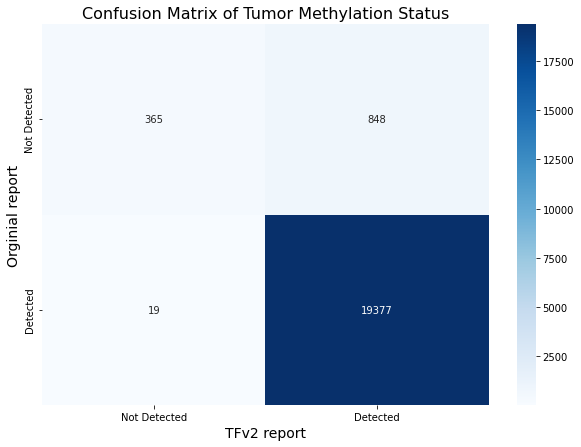

Cohen's Kappa: 0.44


In [45]:
# from sklearn.metrics import confusion_matrix, cohen_kappa_score

# # Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
# map_status = {"Detected": 1, "Not Detected": 0}

# df_sow157_all['Tumor_methylation_status_mapped'] = df_sow157_all['Tumor_methylation_status'].map(map_status)
# df_sow157_final_all['Tumor_methylation_status_mapped'] = df_sow157_final_all['Tumor_methylation_status'].map(map_status)

# # Remove NaN values before creating the confusion matrix
# valid_indices = df_sow157_all['Tumor_methylation_status_mapped'].notna() & df_sow157_final_all['Tumor_methylation_status_mapped'].notna()
# y_true = df_sow157_all[valid_indices]['Tumor_methylation_status_mapped'].values
# y_pred = df_sow157_final_all[valid_indices]['Tumor_methylation_status_mapped'].values

# # Generating the confusion matrix
# cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# # Plotting the confusion matrix
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
# plt.xlabel('TFv2 report', fontsize=14)
# plt.ylabel('Orginial report', fontsize=14)
# plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
# plt.show()

# # Calculating and printing Cohen's Kappa
# kappa = cohen_kappa_score(y_true, y_pred)
# print(f"Cohen's Kappa: {kappa:.2f}")


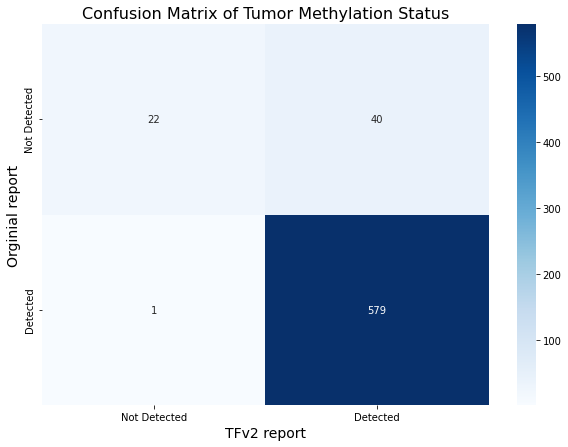

Cohen's Kappa: 0.49


In [17]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow157_2['Tumor_methylation_status_mapped'] = df_sow157_2['Tumor_methylation_status'].map(map_status)
df_sow157_final['Tumor_methylation_status_mapped'] = df_sow157_final['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow157_2['Tumor_methylation_status_mapped'].notna() & df_sow157_final['Tumor_methylation_status_mapped'].notna()
y_true = df_sow157_2[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow157_final[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


# SOW164 TFv2 update

## Data preocessing

In [2]:
# Readin cummulative reports 

# SOW164 need to check the different versions of the delivered report
df_sow164_all = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/data/infinity_report_warehouse/20231106_AstraZeneca_SOW164_46Samples_InfinityReport.csv", header = 0) 

print("Total sample size of SOW164 Infinity cumulative batches is " + str(df_sow164_all.shape[0]) + "\n") 
print("Total unique sample size of SOW164 Infinity cumulative batches is " + str(df_sow164_all.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of SOW164 Infinity cumulative batches is " + str(df_sow164_all.Patient_ID.nunique()) + "\n")

df_sow164_all.head()

Total sample size of SOW164 Infinity cumulative batches is 4493

Total unique sample size of SOW164 Infinity cumulative batches is 46

Total unique patient sample size of SOW164 Infinity cumulative batches is 2



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
1,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,AR,X,66766467.0,1.0,Q493Q,G>A,c.1479G>A,NM_000044.6,38.58,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs141672268,NaN,NaN,NaN,NaN,995.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
2,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LRP5,11,68177585.0,10.0,S765S,G>A,c.2295G>A,NM_002335.4,30.76,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs140955013,Benign,190803.0,NaN,NaN,3461.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
3,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RECQL,12,21624398.0,13.0,K544M,T>A,c.1631A>T,NM_002907.4,30.27,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs74067193,NaN,NaN,NaN,NaN,2517.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
4,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,IL1R1,2,102781466.0,4.0,V98V,A>G,c.294A>G,NM_000877.4,30.18,splice_region_variant,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV52106678,rs144946641,NaN,NaN,NaN,NaN,2350.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable


In [3]:
# Remove duplication
df_sow164_dedup = df_sow164_all.drop_duplicates(subset = "GHSampleID")
df_sow164_dedup.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
157,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002199,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
230,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006219,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
388,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.002646,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
458,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.003135,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable


In [4]:
# Pull "runid" from ghdb
df_sow164_1 = df_sow164_dedup.copy()

# Define the IDs you want to query for
ids = tuple(df_sow164_1['GHSampleID'].unique())

# Generate the SQL query string
query = "SELECT * FROM gh_sample WHERE run_sample_id IN {}".format(ids)

# Get the dataframe with "runid"
sample_df = functions.run_sql_query(query)
sample_df.head()

# Merge "runid" 
sample_df = sample_df.rename(columns={"run_sample_id": "GHSampleID"})
df_sow164_1 = df_sow164_1.merge(sample_df[['GHSampleID', 'runid']], on = 'GHSampleID', how = "left")
df_sow164_1.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7
1,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002199,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7
2,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006219,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7
3,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.002646,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7
4,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.003135,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7


In [5]:
def add_fc_dir_column(df):
    """
    Adds a 'fc_dir' column to the given dataframe, specifying the FC path based on the 'runid' column.

    Args:
        df (pd.DataFrame): A DataFrame that must contain a 'runid' column. This column is used to
                           match directory paths from predefined locations.

    Returns:
        pd.DataFrame: The original dataframe with an added 'fc_dir' column indicating the directory path
                      corresponding to each 'runid'. If no directory is found, the path will be an empty string.
        pd.DataFrame: A DataFrame containing the rows for which no directory path was found.
    """
    # Define the path
    fc_dir_all = "/ghsfa/ivd/flowcentral"
    fc_dir_omni = "/ghsfa/projects/omni_v2/flowcells"
    
    # Initialize a list to store rows where no BIP output was found
    rows_no_found = []
    
    # Initialize the new column in the DataFrame
    df['fc_dir'] = ''
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        runid = row["runid"]
        
        # Find original folder
        pattern_ori = f"{fc_dir_all}/*{runid}*"
        folders = glob.glob(pattern_ori)
        if folders:
            df.loc[index, 'fc_dir'] = folders[0]
        else:
            # Search in the alternative directory if no folder found in the first directory
            pattern_omni = f"{fc_dir_omni}/*{runid}*"
            folders_omni = glob.glob(pattern_omni)
            if folders_omni:
                df.loc[index, 'fc_dir'] = folders_omni[0]
            else:
                # Append the row to the list if no folder is found in either location
                rows_no_found.append(row)
    
    # Create a DataFrame with rows where folders were not found in any sources
    df_no_fc_dir = pd.DataFrame(rows_no_found)
    
    return df, df_no_fc_dir

# Generate the new dataframe 
df_sow164_2, df_no_found = add_fc_dir_column(df_sow164_1)

print("Total sample size of SOW164 Infinity cumulative batches with fc_dir is " + str(df_sow164_1.shape[0]) + "\n") 
print("Total sample size of SOW164 Infinity cumulative batches with NO fc_dir is " + str(df_no_found.shape[0]) + "\n") 

df_sow164_2.head()



Total sample size of SOW164 Infinity cumulative batches with fc_dir is 46

Total sample size of SOW164 Infinity cumulative batches with NO fc_dir is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
1,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002199,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
2,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006219,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510
3,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.002646,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
4,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.003135,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510


## Generate Pancancer S3 MB caller outputs for SOW164
#### Notes:
    1. No cancer type provided
###### Git clone Sirius-1.6.0_Release_Branch for region_file and control_file files for different S3 MB callers
###### Branch https://github.com/guardant/bip-products/blob/Sirius-1.6.0_Release_Branch/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml#L653-L680
###### Confluence page to follow: https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update

In [6]:
# Instead of using epicaller.methylation.methyl_caller funciton, bip-epigenomics module (branch 2.5 with Sirius 1.6 MB caller region/control/module files) is prefered.

def run_bip_epigenomics_module_wrapper_slurm(sample_meta_df, workdir):
    module_dir = '/ghsfa/projects/omni_v2/users/chlee/bip4/bip-epigenomics/' # branch 2.5
    # parameter_set_yaml = "/ghsfa/bik8s/test/bip-portal/outputs/Sirius_LDT_Soft_240905_020053/products/sirius/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6
    parameter_set_yaml = "/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/bip-products/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6


    jobs_dir = f"{workdir}/MB_module_SOW164_jobs"
    output_dir = f"{workdir}/MB_module_SOW164_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        bip_config_json_file = f"{fc_dir}/bip_config.json"
        
        if not os.path.exists(mbd_hyper_molecules):
            continue

        # Make a folder for each run_sample_id
        output_sample_dir = f"{output_dir}/{run_sample_id}"

        if not os.path.exists(output_sample_dir):
            os.makedirs(output_sample_dir)

        # Copy the bip_config.json for each sample from BIP output. This is essential for module running
        # (samples in the same batch shared the same bip_config.json)
        os.system(f"cp {bip_config_json_file} {output_sample_dir}")

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:40:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(f"{module_dir}/module_entry msre_caller " + 
                             f"--in-hyper-molecules {mbd_hyper_molecules} " + 
                             f"--sample-id {run_sample_id} " + 
                             f"--output-dir {output_sample_dir}/ " +
                             f"--parameter-set {parameter_set_yaml} " + 
                             f"--threads 16 " + 
                             f"--memory-log {output_sample_dir}/{run_sample_id}-epigenomics_msre_caller.memory.log " +
                             f"--log-file {output_sample_dir}/{run_sample_id}--epigenomics_msre_caller.log")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [7]:
#run the function to generate all the MB S3 Lung caller ouputs for SOW164 batch 
run_bip_epigenomics_module_wrapper_slurm(df_sow164_2, 
                      f"{work_dir}")

Submitted batch job 86951286
Submitted batch job 86951287
Submitted batch job 86951288
Submitted batch job 86951289
Submitted batch job 86951290
Submitted batch job 86951291
Submitted batch job 86951292
Submitted batch job 86951293
Submitted batch job 86951294
Submitted batch job 86951295
Submitted batch job 86951296
Submitted batch job 86951297
Submitted batch job 86951298
Submitted batch job 86951299
Submitted batch job 86951300
Submitted batch job 86951301
Submitted batch job 86951302
Submitted batch job 86951303
Submitted batch job 86951304
Submitted batch job 86951305
Submitted batch job 86951306
Submitted batch job 86951307
Submitted batch job 86951308
Submitted batch job 86951309
Submitted batch job 86951310
Submitted batch job 86951311
Submitted batch job 86951312
Submitted batch job 86951313
Submitted batch job 86951314
Submitted batch job 86951315
Submitted batch job 86951316
Submitted batch job 86951317
Submitted batch job 86951318
Submitted batch job 86951319
Submitted batc

In [6]:
# Retrieve MB S3 Pancancer caller score

df_sow164_3 = df_sow164_2.copy()

df_sow164_3["MB_pancancer_score"] = np.nan

mb_caller_result_folder = f"{work_dir}/MB_module_SOW164_output"
problematic_rows = []  # List to store indices of problematic rows

for index, crc_row in df_sow164_3.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_pancancer_call.hdr.tsv"

    try:
        msre_df = pd.read_table(msre_mr_file)

        if not msre_df.empty:
            df_sow164_3.at[index, "MB_pancancer_score"] = msre_df.loc[0, "methyl_score"]

        else:
            # Add the index to the list if msre_df is empty
            problematic_rows.append(index) 
            
    except Exception as e:
        # Add the index to the list if there is any other exception
        problematic_rows.append(index)  
        print(f"Error processing file {msre_mr_file}: {str(e)}")

# Create a DataFrame with the indices of the problematic rows
df_problematic = df_sow164_3.loc[problematic_rows]

print("Total sample size of SOW157 Infinity cumulative batches with NO MB output is " + str(df_problematic.shape[0]) + "\n") 

# Returning the DataFrame with problematic rows
df_sow164_3.head()


Total sample size of SOW157 Infinity cumulative batches with NO MB output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.188800
1,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002199,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-9.521482
2,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006219,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-4.675705
3,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.002646,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-7.149700
4,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.003135,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-13.534377


## Generate the epiTFv2 gamma score results

In [9]:
# Temporary solution for TFv2gamma score generation
df_sow164_3 = df_sow164_3[df_sow164_3['Sample_status'] != "FAIL"]
df_sow164_3.shape

# Save the data
df_sow164_3.to_csv(f"{work_dir}/df_sow164_3.csv", index = False)

In [49]:
# Step 1: save the input csv file
df_sow164_3 = pd.read_csv(f"{work_dir}/df_sow164_3.csv", header = 0)
df_sow164_3.head()

# Step 2 generate the slurm script
TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW164_output"

# Check and create directories if not exists
if not os.path.exists(TFv2gamma_output_dir):
    os.makedirs(TFv2gamma_output_dir)

In [27]:
# # Step 2 generate the slurm script

# # Define the contents of the slurm script
# # Parts to updates
#     # sample_list; out_path; slurm_script_path

# slurm_script_content = f"""#! /bin/sh
# #SBATCH --get-user-env
# #SBATCH --job-name TFv2gamma_pancanTF
# #SBATCH --partition dev
# #SBATCH --mem-per-cpu 40G
# #SBATCH --cpus-per-task 1
# #SBATCH --ntasks-per-node 1
# #SBATCH -o {TFv2gamma_output_dir}/epiTFv2gamma_%A.log
# #SBATCH --array 2-1000%300

# module load python/3.9.6;
# export INSTALL_DIR=/home/mcai/workspace/tfv2_gamma/bip-pycommon;
# source $INSTALL_DIR/.py3_venv/bin/activate;
# export PYTHONPATH=$INSTALL_DIR:$PYTHONPATH;

# sample_list={work_dir}/df_sow164_3.csv
# out_path="{TFv2gamma_output_dir}"
# mkdir -p $out_path

# # Extract details from CSV
# fc_dir=$(awk -F "," -v "line=$SLURM_ARRAY_TASK_ID" 'NR==line {{print $56}}' "$sample_list" | sed 's/\\/ghess\\//\\/ghsfa\\/projects\\//')
# sample_id=$(awk -F "," -v "line=$SLURM_ARRAY_TASK_ID" 'NR==line {{print $4}}' "$sample_list")

# # Prepend base path if fc_dir is relative
# base_path="/ghsfa/ivd/flowcentral"
# if [[ "$fc_dir" != /* ]]; then
#     fc_dir="${{base_path}}/${{fc_dir}}"
# fi

# # Construct paths
# sample_path="${{fc_dir}}/${{sample_id}}"
# mbd_path="${{sample_path}}/${{sample_id}}.mbd_hyper_molecules.tsv"
# methyl_qc_file="${{sample_path}}/${{sample_id}}.methyl_qc.tsv"
# subpanel_qc_path="${{mbd_path/mbd_hyper_molecules/subpanel_qc_stats.hdr}}"

# # Run the code
# python -m epi_tumor_fraction.run_epi_tf $mbd_path $methyl_qc_file $out_path $sample_id /ghdevhome/home/mcai/workspace/tfv2_gamma/bip-products/models/Sirius/epi_tf_models/params.sirius.yaml --subpanel_qc_file $subpanel_qc_path
# """

# # Save the slurm script to file
# slurm_script_path = f"{work_dir}/run_TFv2gamma_sow164.sh"
# with open(slurm_script_path, "w") as file:
#     file.write(slurm_script_content)

In [64]:
# Step 2 generate the slurm script

# Define the contents of the slurm script
# Parts to updates
    # sample_list; out_path; slurm_script_path

slurm_script_content = f"""#! /bin/sh
#SBATCH --get-user-env
#SBATCH --job-name TFv2gamma_pancanTF
#SBATCH --partition dev
#SBATCH --mem-per-cpu 40G
#SBATCH --cpus-per-task 1
#SBATCH --ntasks-per-node 1
#SBATCH -o {TFv2gamma_output_dir}/epiTFv2gamma_%A.log
#SBATCH --array 2-1000%300

module load python/3.9.6;
export INSTALL_DIR=/home/mcai/workspace/tfv2_gamma/bip-pycommon;
source $INSTALL_DIR/.py3_venv/bin/activate;
export PYTHONPATH=$INSTALL_DIR:$PYTHONPATH;

sample_list={work_dir}/df_sow164_3.csv
out_path="{TFv2gamma_output_dir}"
mkdir -p $out_path

# Use Python to extract the necessary fields robustly
# Note that the parsing method is changed due to weired parsing issue of "fc_dir" of this sow
read sample_id fc_dir <<< $(python -c "import pandas as pd; import os
df = pd.read_csv('$sample_list')
# Adjusting SLURM_ARRAY_TASK_ID from 1-based to 0-based index
index = int(os.getenv('SLURM_ARRAY_TASK_ID', '1')) - 1
sample_id = df.iloc[index]['GHSampleID']
fc_dir = df.iloc[index]['fc_dir']
print(sample_id, fc_dir)")

# Prepend base path if fc_dir is relative
base_path="/ghsfa/ivd/flowcentral"
if [[ "$fc_dir" != /* ]]; then
    fc_dir="${{base_path}}/${{fc_dir}}"
fi

# Construct paths
sample_path="${{fc_dir}}/${{sample_id}}"
mbd_path="${{sample_path}}/${{sample_id}}.mbd_hyper_molecules.tsv"
methyl_qc_file="${{sample_path}}/${{sample_id}}.methyl_qc.tsv"
subpanel_qc_path="${{mbd_path/mbd_hyper_molecules/subpanel_qc_stats.hdr}}"

# Run the code
python -m epi_tumor_fraction.run_epi_tf $mbd_path $methyl_qc_file $out_path $sample_id /ghdevhome/home/mcai/workspace/tfv2_gamma/bip-products/models/Sirius/epi_tf_models/params.sirius.yaml --subpanel_qc_file $subpanel_qc_path
"""

# Save the slurm script to file
slurm_script_path = f"{work_dir}/run_TFv2gamma_sow164.sh"
with open(slurm_script_path, "w") as file:
    file.write(slurm_script_content)

In [65]:
# Step 3 run the script
os.system(f"sbatch {work_dir}/run_TFv2gamma_sow164.sh")

Submitted batch job 86990279


0

In [7]:
# Retrive the TFv2gamma value

# Remove the "FAIL" samples
df_sow164_4 = df_sow164_3[df_sow164_3["Sample_status"] != "FAIL"]

# Initialize a list to store rows where no TFv2gamma output was found
rows_no_tfv2 = []

df_sow164_4['pred_frac_force'] = None 

TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW164_output"

for index, row in df_sow164_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{TFv2gamma_output_dir}/{sample_id}.epi_tf_model_predictions.tsv"

    file_path_tfv2 = glob.glob(file_path)
    if not file_path_tfv2:
        rows_no_tfv2.append(row)
    
    else:
        try:
            df_temp = pd.read_table(file_path)
            value_gamma = df_temp[df_temp['metric'] == 'epi_tf']['value'].values[0]
            df_sow164_4.at[index, 'pred_frac_force'] = value_gamma
            
        except Exception as e:
            print(f"An error occurred with {sample_id}: {str(e)}")

# Create a DataFrame with rows where folders were not found in any sources
df_no_tfv2 = pd.DataFrame(rows_no_tfv2)
print("Total sample size of SOW164 Infinity cumulative batches with NO TFv2gamma output is " + str(df_no_tfv2.shape[0]) + "\n") 


df_sow164_5 = df_sow164_4.copy()
df_sow164_5.head()

Total sample size of SOW164 Infinity cumulative batches with NO TFv2gamma output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score,pred_frac_force
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.188800,0.006212
1,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002199,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-9.521482,0.002752
2,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006219,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-4.675705,0.006571
3,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.002646,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-7.149700,0.003561
4,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.003135,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-13.534377,0.001942


### For checking troubleshooting purposes on TFv2gamma


In [52]:
# This is for checking troubleshooting purposes

# Sample that has no TFv2gamma output "B00481373"
df_sow164_4 = df_sow164_3[df_sow164_3["GHSampleID"] == "B00481395"]
# df_sow157_4 = df_sow157_3[df_sow157_3["GHSampleID"] == "B00558789"]

# Save the data for test sh run
df_sow164_4.to_csv(f"{work_dir}/df_sow164_4.csv", index = False)
df_sow164_4

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.1888


In [56]:
print(df_sow164_4['fc_dir'])


0    /ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
Name: fc_dir, dtype: object


In [68]:
# STEP 3: run the test script with debugging prints
os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF_test164.sh")

Submitted batch job 86991632


0

## Generate the updated report of SOW157 based on "TFv2" rule 

In [8]:
def update_tumor_methylation_status(df, MB_score_column, MB18_cutoff, MB90_cutoff):
    """
    Update the 'Tumor_methylation_status' and 'Tumor_methylation_score' columns in the DataFrame based on provided cutoff values ('TFv2' rule).
    
    Parameters:
        df (DataFrame): The DataFrame to update. Must with two columns "MB_score_column" and TFv2gamma ("pred_frac_force")
        MB_score_column (str): The column name for MB caller scores.
        MB18_cutoff (float): The cutoff value for the MB18 (must match MB caller type!).
        MB90_cutoff (float): The cutoff value for the MB90 (must match MB caller type!).

    Notes:
        cutoff refenence: https://docs.google.com/presentation/d/1U6TYnddThQHxo9-Ahxpty2ie2_SpnIEcICbTobH4s4g/edit#slide=id.g2f5b7ef9d14_0_50
                          https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update   
    """

    # case1: Addressing flipped calls where "Tumor_methylation_status" is "Not Detected" but TFv2 rule is triggered.
            # Then flip it to "Detected" and replace value "Tumor_methylation_score" with "pred_frac_force"
    conditions_case1 = (
        (df['Tumor_methylation_status'] == 'Not Detected') &
        ((df[MB_score_column] >= MB90_cutoff) |
         ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case2: Addressing flipped calls where "Tumor_methylation_status" is "Detected" but TFv2 rule is NOT triggered. 
            # Then flip it to "Not Detected" and replace value "Tumor_methylation_score" with 0
    conditions_case2 = (
        (df['Tumor_methylation_status'] == 'Detected') &
        ~((df[MB_score_column] >= MB90_cutoff) |
          ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case3: "Tumor_methylation_status" is nan for FAIL samples. No updates

    # Apply updates based on conditions
    df.loc[conditions_case1, 'Tumor_methylation_status'] = 'Detected'
    df.loc[conditions_case1, 'Tumor_methylation_score'] = df.loc[conditions_case1, 'pred_frac_force']

    df.loc[conditions_case2, 'Tumor_methylation_status'] = 'Not Detected'
    df.loc[conditions_case2, 'Tumor_methylation_score'] = 0

    # Replace the udpated "Tumor_methylation_score" with "pred_frac_force" when "Tumor_methylation_status" is "Detected"
    df['Tumor_methylation_score'] = np.where(df['Tumor_methylation_status'] == "Detected", df['pred_frac_force'], df['Tumor_methylation_score'])

    return df

# Run pancancer caller cutoffs for the SOW: MB18: -22.289441; MB90: -20.907684
df_sow164_updated = update_tumor_methylation_status(df_sow164_5, 'MB_pancancer_score', -22.289441, -20.907684)

df_sow164_updated.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score,pred_frac_force
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.188800,0.006212
1,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002752,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-9.521482,0.002752
2,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006571,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-4.675705,0.006571
3,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.003561,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-7.149700,0.003561
4,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.001942,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-13.534377,0.001942


In [9]:
# Genearte the final report

# Subset the updated report for updated MB score and TFv2gamma columns
df_sow164_5_sub = df_sow164_updated[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']]
df_sow164_5_sub_dedup = df_sow164_5_sub.drop_duplicates(subset = 'GHSampleID')
print("Total sample size of SOW164 Infinity cumulative batches with updated MB score and TFv2gamma is " + str(df_sow164_5_sub_dedup.shape[0]) + "\n") 

# Drop duplicates of original report
df_sow164_all_dedup = df_sow164_all.drop_duplicates(subset = "GHSampleID")
print("Total sample size of original SOW164 Infinity cumulative batches is " + str(df_sow164_all_dedup.shape[0]) + "\n") 

# Check failed samples
df_sow164_all_dedup.Sample_status.value_counts()


Total sample size of SOW164 Infinity cumulative batches with updated MB score and TFv2gamma is 46

Total sample size of original SOW164 Infinity cumulative batches is 46



SUCCESS    46
Name: Sample_status, dtype: int64

In [10]:
# Update the column values while maintaining the original column order not changed

# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow164_all_dedup.merge(df_sow164_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow??_final
df_sow164_final = df_merged[df_sow164_all_dedup.columns]

# Save the data
df_sow164_final.to_csv(f"{work_dir}/df_sow164_final.csv", index = False)

df_sow164_final.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
1,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002752,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
2,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006571,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
3,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.003561,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
4,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.001942,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable


In [11]:
# Update the column values while maintaining the original column order not changed

# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow164_all.merge(df_sow164_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow1??_final
df_sow164_final_all = df_merged[df_sow164_all.columns]

# Save the data
df_sow164_final_all.to_csv(f"{work_dir}/df_sow164_final_all.csv", index = False)

df_sow164_final_all.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
1,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,AR,X,66766467.0,1.0,Q493Q,G>A,c.1479G>A,NM_000044.6,38.58,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs141672268,NaN,NaN,NaN,NaN,995.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
2,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LRP5,11,68177585.0,10.0,S765S,G>A,c.2295G>A,NM_002335.4,30.76,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs140955013,Benign,190803.0,NaN,NaN,3461.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
3,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RECQL,12,21624398.0,13.0,K544M,T>A,c.1631A>T,NM_002907.4,30.27,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs74067193,NaN,NaN,NaN,NaN,2517.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
4,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,IL1R1,2,102781466.0,4.0,V98V,A>G,c.294A>G,NM_000877.4,30.18,splice_region_variant,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV52106678,rs144946641,NaN,NaN,NaN,NaN,2350.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable


In [12]:
df_sow164_final_all.shape

(4493, 56)

In [13]:
df_sow164_final.shape

(46, 56)

## Data Visualization

### Confusion Matrix

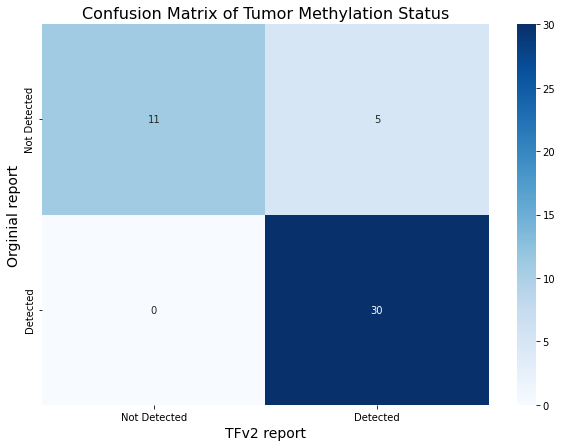

Cohen's Kappa: 0.74


In [14]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow164_2['Tumor_methylation_status_mapped'] = df_sow164_2['Tumor_methylation_status'].map(map_status)
df_sow164_final['Tumor_methylation_status_mapped'] = df_sow164_final['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow164_2['Tumor_methylation_status_mapped'].notna() & df_sow164_final['Tumor_methylation_status_mapped'].notna()
y_true = df_sow164_2[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow164_final[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


# SOW164 TFv2 update

## Data preocessing

In [ ]:
# Readin cummulative reports 

# SOW164 need to check the different versions of the delivered report
df_sow164_all = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/data/infinity_report_warehouse/20231106_AstraZeneca_SOW164_46Samples_InfinityReport.csv", header = 0) 

print("Total sample size of SOW164 Infinity cumulative batches is " + str(df_sow164_all.shape[0]) + "\n") 
print("Total unique sample size of SOW164 Infinity cumulative batches is " + str(df_sow164_all.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of SOW164 Infinity cumulative batches is " + str(df_sow164_all.Patient_ID.nunique()) + "\n")

df_sow164_all.head()

Total sample size of SOW164 Infinity cumulative batches is 4493

Total unique sample size of SOW164 Infinity cumulative batches is 46

Total unique patient sample size of SOW164 Infinity cumulative batches is 2



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
1,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,AR,X,66766467.0,1.0,Q493Q,G>A,c.1479G>A,NM_000044.6,38.58,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs141672268,NaN,NaN,NaN,NaN,995.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
2,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LRP5,11,68177585.0,10.0,S765S,G>A,c.2295G>A,NM_002335.4,30.76,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs140955013,Benign,190803.0,NaN,NaN,3461.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
3,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RECQL,12,21624398.0,13.0,K544M,T>A,c.1631A>T,NM_002907.4,30.27,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs74067193,NaN,NaN,NaN,NaN,2517.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
4,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,IL1R1,2,102781466.0,4.0,V98V,A>G,c.294A>G,NM_000877.4,30.18,splice_region_variant,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV52106678,rs144946641,NaN,NaN,NaN,NaN,2350.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable


In [ ]:
# Remove duplication
df_sow164_dedup = df_sow164_all.drop_duplicates(subset = "GHSampleID")
df_sow164_dedup.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
157,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002199,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
230,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006219,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
388,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.002646,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
458,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.003135,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable


In [ ]:
# Pull "runid" from ghdb
df_sow164_1 = df_sow164_dedup.copy()

# Define the IDs you want to query for
ids = tuple(df_sow164_1['GHSampleID'].unique())

# Generate the SQL query string
query = "SELECT * FROM gh_sample WHERE run_sample_id IN {}".format(ids)

# Get the dataframe with "runid"
sample_df = functions.run_sql_query(query)
sample_df.head()

# Merge "runid" 
sample_df = sample_df.rename(columns={"run_sample_id": "GHSampleID"})
df_sow164_1 = df_sow164_1.merge(sample_df[['GHSampleID', 'runid']], on = 'GHSampleID', how = "left")
df_sow164_1.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7
1,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002199,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7
2,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006219,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7
3,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.002646,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7
4,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.003135,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7


In [ ]:
def add_fc_dir_column(df):
    """
    Adds a 'fc_dir' column to the given dataframe, specifying the FC path based on the 'runid' column.

    Args:
        df (pd.DataFrame): A DataFrame that must contain a 'runid' column. This column is used to
                           match directory paths from predefined locations.

    Returns:
        pd.DataFrame: The original dataframe with an added 'fc_dir' column indicating the directory path
                      corresponding to each 'runid'. If no directory is found, the path will be an empty string.
        pd.DataFrame: A DataFrame containing the rows for which no directory path was found.
    """
    # Define the path
    fc_dir_all = "/ghsfa/ivd/flowcentral"
    fc_dir_omni = "/ghsfa/projects/omni_v2/flowcells"
    
    # Initialize a list to store rows where no BIP output was found
    rows_no_found = []
    
    # Initialize the new column in the DataFrame
    df['fc_dir'] = ''
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        runid = row["runid"]
        
        # Find original folder
        pattern_ori = f"{fc_dir_all}/*{runid}*"
        folders = glob.glob(pattern_ori)
        if folders:
            df.loc[index, 'fc_dir'] = folders[0]
        else:
            # Search in the alternative directory if no folder found in the first directory
            pattern_omni = f"{fc_dir_omni}/*{runid}*"
            folders_omni = glob.glob(pattern_omni)
            if folders_omni:
                df.loc[index, 'fc_dir'] = folders_omni[0]
            else:
                # Append the row to the list if no folder is found in either location
                rows_no_found.append(row)
    
    # Create a DataFrame with rows where folders were not found in any sources
    df_no_fc_dir = pd.DataFrame(rows_no_found)
    
    return df, df_no_fc_dir

# Generate the new dataframe 
df_sow164_2, df_no_found = add_fc_dir_column(df_sow164_1)

print("Total sample size of SOW164 Infinity cumulative batches with fc_dir is " + str(df_sow164_1.shape[0]) + "\n") 
print("Total sample size of SOW164 Infinity cumulative batches with NO fc_dir is " + str(df_no_found.shape[0]) + "\n") 

df_sow164_2.head()



Total sample size of SOW164 Infinity cumulative batches with fc_dir is 46

Total sample size of SOW164 Infinity cumulative batches with NO fc_dir is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
1,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002199,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
2,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006219,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510
3,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.002646,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
4,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.003135,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510


## Generate Pancancer S3 MB caller outputs for SOW164
#### Notes:
    1. No cancer type provided
###### Git clone Sirius-1.6.0_Release_Branch for region_file and control_file files for different S3 MB callers
###### Branch https://github.com/guardant/bip-products/blob/Sirius-1.6.0_Release_Branch/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml#L653-L680
###### Confluence page to follow: https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update

In [ ]:
# Instead of using epicaller.methylation.methyl_caller funciton, bip-epigenomics module (branch 2.5 with Sirius 1.6 MB caller region/control/module files) is prefered.

def run_bip_epigenomics_module_wrapper_slurm(sample_meta_df, workdir):
    module_dir = '/ghsfa/projects/omni_v2/users/chlee/bip4/bip-epigenomics/' # branch 2.5
    # parameter_set_yaml = "/ghsfa/bik8s/test/bip-portal/outputs/Sirius_LDT_Soft_240905_020053/products/sirius/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6
    parameter_set_yaml = "/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/bip-products/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6


    jobs_dir = f"{workdir}/MB_module_SOW164_jobs"
    output_dir = f"{workdir}/MB_module_SOW164_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        bip_config_json_file = f"{fc_dir}/bip_config.json"
        
        if not os.path.exists(mbd_hyper_molecules):
            continue

        # Make a folder for each run_sample_id
        output_sample_dir = f"{output_dir}/{run_sample_id}"

        if not os.path.exists(output_sample_dir):
            os.makedirs(output_sample_dir)

        # Copy the bip_config.json for each sample from BIP output. This is essential for module running
        # (samples in the same batch shared the same bip_config.json)
        os.system(f"cp {bip_config_json_file} {output_sample_dir}")

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:40:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(f"{module_dir}/module_entry msre_caller " + 
                             f"--in-hyper-molecules {mbd_hyper_molecules} " + 
                             f"--sample-id {run_sample_id} " + 
                             f"--output-dir {output_sample_dir}/ " +
                             f"--parameter-set {parameter_set_yaml} " + 
                             f"--threads 16 " + 
                             f"--memory-log {output_sample_dir}/{run_sample_id}-epigenomics_msre_caller.memory.log " +
                             f"--log-file {output_sample_dir}/{run_sample_id}--epigenomics_msre_caller.log")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [ ]:
#run the function to generate all the MB S3 Lung caller ouputs for SOW164 batch 
run_bip_epigenomics_module_wrapper_slurm(df_sow164_2, 
                      f"{work_dir}")

Submitted batch job 86951286
Submitted batch job 86951287
Submitted batch job 86951288
Submitted batch job 86951289
Submitted batch job 86951290
Submitted batch job 86951291
Submitted batch job 86951292
Submitted batch job 86951293
Submitted batch job 86951294
Submitted batch job 86951295
Submitted batch job 86951296
Submitted batch job 86951297
Submitted batch job 86951298
Submitted batch job 86951299
Submitted batch job 86951300
Submitted batch job 86951301
Submitted batch job 86951302
Submitted batch job 86951303
Submitted batch job 86951304
Submitted batch job 86951305
Submitted batch job 86951306
Submitted batch job 86951307
Submitted batch job 86951308
Submitted batch job 86951309
Submitted batch job 86951310
Submitted batch job 86951311
Submitted batch job 86951312
Submitted batch job 86951313
Submitted batch job 86951314
Submitted batch job 86951315
Submitted batch job 86951316
Submitted batch job 86951317
Submitted batch job 86951318
Submitted batch job 86951319
Submitted batc

In [ ]:
# Retrieve MB S3 Pancancer caller score

df_sow164_3 = df_sow164_2.copy()

df_sow164_3["MB_pancancer_score"] = np.nan

mb_caller_result_folder = f"{work_dir}/MB_module_SOW164_output"
problematic_rows = []  # List to store indices of problematic rows

for index, crc_row in df_sow164_3.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_pancancer_call.hdr.tsv"

    try:
        msre_df = pd.read_table(msre_mr_file)

        if not msre_df.empty:
            df_sow164_3.at[index, "MB_pancancer_score"] = msre_df.loc[0, "methyl_score"]

        else:
            # Add the index to the list if msre_df is empty
            problematic_rows.append(index) 
            
    except Exception as e:
        # Add the index to the list if there is any other exception
        problematic_rows.append(index)  
        print(f"Error processing file {msre_mr_file}: {str(e)}")

# Create a DataFrame with the indices of the problematic rows
df_problematic = df_sow164_3.loc[problematic_rows]

print("Total sample size of SOW157 Infinity cumulative batches with NO MB output is " + str(df_problematic.shape[0]) + "\n") 

# Returning the DataFrame with problematic rows
df_sow164_3.head()


Total sample size of SOW157 Infinity cumulative batches with NO MB output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.188800
1,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002199,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-9.521482
2,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006219,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-4.675705
3,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.002646,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-7.149700
4,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.003135,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-13.534377


## Generate the epiTFv2 gamma score results

In [ ]:
# Temporary solution for TFv2gamma score generation
df_sow164_3 = df_sow164_3[df_sow164_3['Sample_status'] != "FAIL"]
df_sow164_3.shape

# Save the data
df_sow164_3.to_csv(f"{work_dir}/df_sow164_3.csv", index = False)

In [ ]:
# Step 1: save the input csv file
df_sow164_3 = pd.read_csv(f"{work_dir}/df_sow164_3.csv", header = 0)
df_sow164_3.head()

# Step 2 generate the slurm script
TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW164_output"

# Check and create directories if not exists
if not os.path.exists(TFv2gamma_output_dir):
    os.makedirs(TFv2gamma_output_dir)

In [ ]:
# # Step 2 generate the slurm script

# # Define the contents of the slurm script
# # Parts to updates
#     # sample_list; out_path; slurm_script_path

# slurm_script_content = f"""#! /bin/sh
# #SBATCH --get-user-env
# #SBATCH --job-name TFv2gamma_pancanTF
# #SBATCH --partition dev
# #SBATCH --mem-per-cpu 40G
# #SBATCH --cpus-per-task 1
# #SBATCH --ntasks-per-node 1
# #SBATCH -o {TFv2gamma_output_dir}/epiTFv2gamma_%A.log
# #SBATCH --array 2-1000%300

# module load python/3.9.6;
# export INSTALL_DIR=/home/mcai/workspace/tfv2_gamma/bip-pycommon;
# source $INSTALL_DIR/.py3_venv/bin/activate;
# export PYTHONPATH=$INSTALL_DIR:$PYTHONPATH;

# sample_list={work_dir}/df_sow164_3.csv
# out_path="{TFv2gamma_output_dir}"
# mkdir -p $out_path

# # Extract details from CSV
# fc_dir=$(awk -F "," -v "line=$SLURM_ARRAY_TASK_ID" 'NR==line {{print $56}}' "$sample_list" | sed 's/\\/ghess\\//\\/ghsfa\\/projects\\//')
# sample_id=$(awk -F "," -v "line=$SLURM_ARRAY_TASK_ID" 'NR==line {{print $4}}' "$sample_list")

# # Prepend base path if fc_dir is relative
# base_path="/ghsfa/ivd/flowcentral"
# if [[ "$fc_dir" != /* ]]; then
#     fc_dir="${{base_path}}/${{fc_dir}}"
# fi

# # Construct paths
# sample_path="${{fc_dir}}/${{sample_id}}"
# mbd_path="${{sample_path}}/${{sample_id}}.mbd_hyper_molecules.tsv"
# methyl_qc_file="${{sample_path}}/${{sample_id}}.methyl_qc.tsv"
# subpanel_qc_path="${{mbd_path/mbd_hyper_molecules/subpanel_qc_stats.hdr}}"

# # Run the code
# python -m epi_tumor_fraction.run_epi_tf $mbd_path $methyl_qc_file $out_path $sample_id /ghdevhome/home/mcai/workspace/tfv2_gamma/bip-products/models/Sirius/epi_tf_models/params.sirius.yaml --subpanel_qc_file $subpanel_qc_path
# """

# # Save the slurm script to file
# slurm_script_path = f"{work_dir}/run_TFv2gamma_sow164.sh"
# with open(slurm_script_path, "w") as file:
#     file.write(slurm_script_content)

In [ ]:
# Step 2 generate the slurm script

# Define the contents of the slurm script
# Parts to updates
    # sample_list; out_path; slurm_script_path

slurm_script_content = f"""#! /bin/sh
#SBATCH --get-user-env
#SBATCH --job-name TFv2gamma_pancanTF
#SBATCH --partition dev
#SBATCH --mem-per-cpu 40G
#SBATCH --cpus-per-task 1
#SBATCH --ntasks-per-node 1
#SBATCH -o {TFv2gamma_output_dir}/epiTFv2gamma_%A.log
#SBATCH --array 2-1000%300

module load python/3.9.6;
export INSTALL_DIR=/home/mcai/workspace/tfv2_gamma/bip-pycommon;
source $INSTALL_DIR/.py3_venv/bin/activate;
export PYTHONPATH=$INSTALL_DIR:$PYTHONPATH;

sample_list={work_dir}/df_sow164_3.csv
out_path="{TFv2gamma_output_dir}"
mkdir -p $out_path

# Use Python to extract the necessary fields robustly
# Note that the parsing method is changed due to weired parsing issue of "fc_dir" of this sow
read sample_id fc_dir <<< $(python -c "import pandas as pd; import os
df = pd.read_csv('$sample_list')
# Adjusting SLURM_ARRAY_TASK_ID from 1-based to 0-based index
index = int(os.getenv('SLURM_ARRAY_TASK_ID', '1')) - 1
sample_id = df.iloc[index]['GHSampleID']
fc_dir = df.iloc[index]['fc_dir']
print(sample_id, fc_dir)")

# Prepend base path if fc_dir is relative
base_path="/ghsfa/ivd/flowcentral"
if [[ "$fc_dir" != /* ]]; then
    fc_dir="${{base_path}}/${{fc_dir}}"
fi

# Construct paths
sample_path="${{fc_dir}}/${{sample_id}}"
mbd_path="${{sample_path}}/${{sample_id}}.mbd_hyper_molecules.tsv"
methyl_qc_file="${{sample_path}}/${{sample_id}}.methyl_qc.tsv"
subpanel_qc_path="${{mbd_path/mbd_hyper_molecules/subpanel_qc_stats.hdr}}"

# Run the code
python -m epi_tumor_fraction.run_epi_tf $mbd_path $methyl_qc_file $out_path $sample_id /ghdevhome/home/mcai/workspace/tfv2_gamma/bip-products/models/Sirius/epi_tf_models/params.sirius.yaml --subpanel_qc_file $subpanel_qc_path
"""

# Save the slurm script to file
slurm_script_path = f"{work_dir}/run_TFv2gamma_sow164.sh"
with open(slurm_script_path, "w") as file:
    file.write(slurm_script_content)

In [ ]:
# Step 3 run the script
os.system(f"sbatch {work_dir}/run_TFv2gamma_sow164.sh")

Submitted batch job 86990279


0

In [ ]:
# Retrive the TFv2gamma value

# Remove the "FAIL" samples
df_sow164_4 = df_sow164_3[df_sow164_3["Sample_status"] != "FAIL"]

# Initialize a list to store rows where no TFv2gamma output was found
rows_no_tfv2 = []

df_sow164_4['pred_frac_force'] = None 

TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW164_output"

for index, row in df_sow164_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{TFv2gamma_output_dir}/{sample_id}.epi_tf_model_predictions.tsv"

    file_path_tfv2 = glob.glob(file_path)
    if not file_path_tfv2:
        rows_no_tfv2.append(row)
    
    else:
        try:
            df_temp = pd.read_table(file_path)
            value_gamma = df_temp[df_temp['metric'] == 'epi_tf']['value'].values[0]
            df_sow164_4.at[index, 'pred_frac_force'] = value_gamma
            
        except Exception as e:
            print(f"An error occurred with {sample_id}: {str(e)}")

# Create a DataFrame with rows where folders were not found in any sources
df_no_tfv2 = pd.DataFrame(rows_no_tfv2)
print("Total sample size of SOW164 Infinity cumulative batches with NO TFv2gamma output is " + str(df_no_tfv2.shape[0]) + "\n") 


df_sow164_5 = df_sow164_4.copy()
df_sow164_5.head()

Total sample size of SOW164 Infinity cumulative batches with NO TFv2gamma output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score,pred_frac_force
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.188800,0.006212
1,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002199,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-9.521482,0.002752
2,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006219,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-4.675705,0.006571
3,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.002646,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-7.149700,0.003561
4,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.003135,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-13.534377,0.001942


### For checking troubleshooting purposes on TFv2gamma


In [ ]:
# This is for checking troubleshooting purposes

# Sample that has no TFv2gamma output "B00481373"
df_sow164_4 = df_sow164_3[df_sow164_3["GHSampleID"] == "B00481395"]
# df_sow157_4 = df_sow157_3[df_sow157_3["GHSampleID"] == "B00558789"]

# Save the data for test sh run
df_sow164_4.to_csv(f"{work_dir}/df_sow164_4.csv", index = False)
df_sow164_4

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.1888


In [ ]:
print(df_sow164_4['fc_dir'])


0    /ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
Name: fc_dir, dtype: object


In [ ]:
# STEP 3: run the test script with debugging prints
os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF_test164.sh")

Submitted batch job 86991632


0

## Generate the updated report of SOW157 based on "TFv2" rule 

In [ ]:
def update_tumor_methylation_status(df, MB_score_column, MB18_cutoff, MB90_cutoff):
    """
    Update the 'Tumor_methylation_status' and 'Tumor_methylation_score' columns in the DataFrame based on provided cutoff values ('TFv2' rule).
    
    Parameters:
        df (DataFrame): The DataFrame to update. Must with two columns "MB_score_column" and TFv2gamma ("pred_frac_force")
        MB_score_column (str): The column name for MB caller scores.
        MB18_cutoff (float): The cutoff value for the MB18 (must match MB caller type!).
        MB90_cutoff (float): The cutoff value for the MB90 (must match MB caller type!).

    Notes:
        cutoff refenence: https://docs.google.com/presentation/d/1U6TYnddThQHxo9-Ahxpty2ie2_SpnIEcICbTobH4s4g/edit#slide=id.g2f5b7ef9d14_0_50
                          https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update   
    """

    # case1: Addressing flipped calls where "Tumor_methylation_status" is "Not Detected" but TFv2 rule is triggered.
            # Then flip it to "Detected" and replace value "Tumor_methylation_score" with "pred_frac_force"
    conditions_case1 = (
        (df['Tumor_methylation_status'] == 'Not Detected') &
        ((df[MB_score_column] >= MB90_cutoff) |
         ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case2: Addressing flipped calls where "Tumor_methylation_status" is "Detected" but TFv2 rule is NOT triggered. 
            # Then flip it to "Not Detected" and replace value "Tumor_methylation_score" with 0
    conditions_case2 = (
        (df['Tumor_methylation_status'] == 'Detected') &
        ~((df[MB_score_column] >= MB90_cutoff) |
          ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case3: "Tumor_methylation_status" is nan for FAIL samples. No updates

    # Apply updates based on conditions
    df.loc[conditions_case1, 'Tumor_methylation_status'] = 'Detected'
    df.loc[conditions_case1, 'Tumor_methylation_score'] = df.loc[conditions_case1, 'pred_frac_force']

    df.loc[conditions_case2, 'Tumor_methylation_status'] = 'Not Detected'
    df.loc[conditions_case2, 'Tumor_methylation_score'] = 0

    # Replace the udpated "Tumor_methylation_score" with "pred_frac_force" when "Tumor_methylation_status" is "Detected"
    df['Tumor_methylation_score'] = np.where(df['Tumor_methylation_status'] == "Detected", df['pred_frac_force'], df['Tumor_methylation_score'])

    return df

# Run pancancer caller cutoffs for the SOW: MB18: -22.289441; MB90: -20.907684
df_sow164_updated = update_tumor_methylation_status(df_sow164_5, 'MB_pancancer_score', -22.289441, -20.907684)

df_sow164_updated.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score,pred_frac_force
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.188800,0.006212
1,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002752,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-9.521482,0.002752
2,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006571,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-4.675705,0.006571
3,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.003561,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-7.149700,0.003561
4,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.001942,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00441_0862_BHCFLCDSX7,/ghsfa/ivd/flowcentral/230908_A00441_0862_BHCFLCDSX7.bacd02eb-9710-4816-a1dc-194a7a5a55ae.20230910113510,-13.534377,0.001942


In [ ]:
# Genearte the final report

# Subset the updated report for updated MB score and TFv2gamma columns
df_sow164_5_sub = df_sow164_updated[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']]
df_sow164_5_sub_dedup = df_sow164_5_sub.drop_duplicates(subset = 'GHSampleID')
print("Total sample size of SOW164 Infinity cumulative batches with updated MB score and TFv2gamma is " + str(df_sow164_5_sub_dedup.shape[0]) + "\n") 

# Drop duplicates of original report
df_sow164_all_dedup = df_sow164_all.drop_duplicates(subset = "GHSampleID")
print("Total sample size of original SOW164 Infinity cumulative batches is " + str(df_sow164_all_dedup.shape[0]) + "\n") 

# Check failed samples
df_sow164_all_dedup.Sample_status.value_counts()


Total sample size of SOW164 Infinity cumulative batches with updated MB score and TFv2gamma is 46

Total sample size of original SOW164 Infinity cumulative batches is 46



SUCCESS    46
Name: Sample_status, dtype: int64

In [ ]:
# Update the column values while maintaining the original column order not changed

# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow164_all_dedup.merge(df_sow164_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow??_final
df_sow164_final = df_merged[df_sow164_all_dedup.columns]

# Save the data
df_sow164_final.to_csv(f"{work_dir}/df_sow164_final.csv", index = False)

df_sow164_final.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.140,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
1,MR_MATRIX,MR_set3_s18,A0837797,B00481352,MR_Set-3,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RSPO1,1,38079537.0,7.0,P155L,G>A,c.464C>T,NM_001038633.4,49.92,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV62973558,rs201102260,NaN,NaN,NaN,NaN,2339.0,0.000,NaN,NaN,Detected,0.002752,NaN,Not evaluable,Not Detected,17.264,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
2,MR_MATRIX,MR_set 1_s18,A0837774,B00481400,MR_Set-1,C1D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.04,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1452.0,0.350,NaN,NaN,Detected,0.006571,NaN,Not evaluable,Detected,14.248,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
3,MR_MATRIX,MR_set3_s21,A0837800,B00481373,MR_Set-3,C1D1,1.0,SUCCESS,NaN,SNV,NaN,FAAP20,1,2125440.0,6.0,G168G,T>C,c.504A>G,NM_001282670.2,49.57,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147283443,NaN,NaN,NaN,NaN,2174.0,0.000,NaN,NaN,Detected,0.003561,NaN,Not evaluable,Not Detected,18.252,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
4,MR_MATRIX,MR_set 1_s1,A0837757,B00481344,MR_Set-1,C2D1,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,58.69,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,993.0,0.000,NaN,NaN,Detected,0.001942,NaN,Not evaluable,Not Detected,8.060,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable


In [ ]:
# Update the column values while maintaining the original column order not changed

# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow164_all.merge(df_sow164_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow1??_final
df_sow164_final_all = df_merged[df_sow164_all.columns]

# Save the data
df_sow164_final_all.to_csv(f"{work_dir}/df_sow164_final_all.csv", index = False)

df_sow164_final_all.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
1,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,AR,X,66766467.0,1.0,Q493Q,G>A,c.1479G>A,NM_000044.6,38.58,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs141672268,NaN,NaN,NaN,NaN,995.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
2,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LRP5,11,68177585.0,10.0,S765S,G>A,c.2295G>A,NM_002335.4,30.76,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs140955013,Benign,190803.0,NaN,NaN,3461.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
3,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,RECQL,12,21624398.0,13.0,K544M,T>A,c.1631A>T,NM_002907.4,30.27,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs74067193,NaN,NaN,NaN,NaN,2517.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable
4,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,IL1R1,2,102781466.0,4.0,V98V,A>G,c.294A>G,NM_000877.4,30.18,splice_region_variant,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV52106678,rs144946641,NaN,NaN,NaN,NaN,2350.0,0.303,NaN,NaN,Detected,0.006212,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable


In [ ]:
df_sow164_final_all.shape

(4493, 56)

In [ ]:
df_sow164_final.shape

(46, 56)

## Data Visualization

### Confusion Matrix

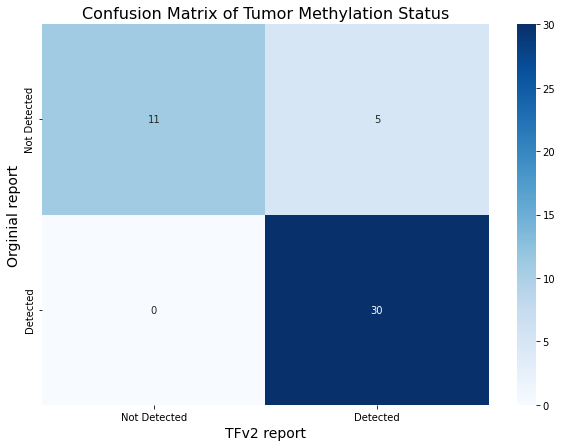

Cohen's Kappa: 0.74


In [ ]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow164_2['Tumor_methylation_status_mapped'] = df_sow164_2['Tumor_methylation_status'].map(map_status)
df_sow164_final['Tumor_methylation_status_mapped'] = df_sow164_final['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow164_2['Tumor_methylation_status_mapped'].notna() & df_sow164_final['Tumor_methylation_status_mapped'].notna()
y_true = df_sow164_2[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow164_final[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")
